# Transformer model for language understanding

Основная идея, лежащая в основе модели Transformer, - это самовнимание - способность отслеживать различные позиции входной последовательности для вычисления представления этой последовательности. Transformer создает стопки слоев самовнимания, что объясняется ниже в разделах « Масштабируемое скалярное произведение» и « Многоголовое внимание» .

Модель преобразователя обрабатывает входные данные переменного размера, используя стопки слоев самовнимания вместо RNN или CNN . Эта общая архитектура имеет ряд преимуществ:

* Он не делает никаких предположений о временных / пространственных отношениях между данными. Это идеально подходит для обработки набора объектов.
* Выходы уровня можно вычислять параллельно, а не последовательно, как RNN.
* Отдаленные элементы могут влиять на вывод друг друга, не проходя через множество RNN-шагов или слоев свертки (например, см. Преобразователь памяти сцены ).
* Он может изучать дальнодействующие зависимости. Это проблема для многих задач последовательности.

Минусы этой архитектуры:

* Для временного ряда выход для временного шага рассчитывается из всей истории, а не только из входных данных и текущего скрытого состояния. Это может быть менее эффективно.
* Если вход действительно имеет временное / пространственное соотношение, как текст, должно быть добавлено некоторое позиционное кодирование или модель будет эффективно увидеть мешок слов.

После обучения модели вы сможете ввести предложение на русском и вернуть перевод на английском.


<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [ ]:
!pip install -q tfds-nightly

# Pin matplotlib version to 3.2.2 since in the latest version
# transformer.ipynb fails with the following error:
# https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
!pip install matplotlib==3.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 34.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## Setup input pipeline

Use [TFDS](https://www.tensorflow.org/datasets) to load the Ru-English translation dataset from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Создайте собственный токенизатор подслов из training dataset. 

In [ ]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for ru, en in train_examples), target_vocab_size=2**13)

tokenizer_ru = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (ru.numpy() for ru, en in train_examples), target_vocab_size=2**13)

In [ ]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [8073, 1034, 8104, 5774, 13, 3531, 8035]
The original string: Transformer is awesome.


Токенизатор кодирует строку, разбивая ее на подслова, если слово отсутствует в его словаре.



In [ ]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

8073 ----> T
1034 ----> ran
8104 ----> s
5774 ----> former 
13 ----> is 
3531 ----> awesome
8035 ----> .


In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Добавьте начальный и конечный токены к входу и цели.

In [ ]:
# two tokenizers (tokenizer_ru and tokenizer_en) are used to encode two languages (lang1 and lang2). 
# The encode method is then called on each language, which adds the beginning and end of sequence tokens 
# (tokenizer_ru.vocabsize and tokenizer_en.vocabsize+1) to the encoded text. Finally, the encoded text for both 
# languages is returned as a tuple.

def encode(lang1, lang2):
  lang1 = [tokenizer_ru.vocab_size] + tokenizer_ru.encode(
      lang1.numpy()) + [tokenizer_ru.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

Вы хотите использовать Dataset.map чтобы применить эту функцию к каждому элементу набора данных. Dataset.map работает в графическом режиме.

Тензоры графов не имеют значения.
В графическом режиме вы можете использовать только операции и функции TensorFlow.
Таким образом, вы не можете напрямую .map эту функцию: вам нужно обернуть ее в tf.py_function . tf.py_function будет передавать обычные тензоры (со значением и .numpy() для доступа к нему) в .numpy() функцию python.



In [ ]:
def tf_encode(ru, en):

# tf.pyfunction method is used to call a custom function (encode) with two arguments (ru and en). 
# The two arguments are then mapped to two data types (tf.int64, tf.int64) which will be returned as a tuple containing two Tensors.
  result_ru, result_en = tf.py_function(encode, [ru, en], [tf.int64, tf.int64])

#set_shape method is used to set the shape of each Tensor to [None], which means that it will be able to accept variable-length inputs.
  result_ru.set_shape([None]) 
  result_en.set_shape([None])

  return result_ru, result_en

In [ ]:
MAX_LENGTH = 40

In [ ]:
# filter out examples that have a length greater than the specified maxlength. 
# This is done by checking the length of both x and y using the tf.size method and then using the tf.logicaland method to return
#  a boolean value indicating if both lengths are less than the specified max_length.

In [ ]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE) # create batches of data in which the examples are padded with zeros to match the maximum length.

In [ ]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8179,   57,   86, ...,    0,    0,    0],
        [8179,    3,   38, ...,    0,    0,    0],
        [8179,   57,  135, ...,    0,    0,    0],
        ...,
        [8179,    3,    7, ...,    0,    0,    0],
        [8179,  138,  250, ...,    0,    0,    0],
        [8179,   19,    7, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8245,   90,  101, ...,    0,    0,    0],
        [8245,   70,   25, ...,    0,    0,    0],
        [8245,   90,  153, ...,    0,    0,    0],
        ...,
        [8245,    4,   18, ...,    0,    0,    0],
        [8245,   19,   59, ...,    0,    0,    0],
        [8245,   24,   18, ...,    0,    0,    0]])>)

## Positional encoding

Поскольку эта модель не содержит повторений или сверток, добавляется позиционное кодирование, чтобы дать модели некоторую информацию об относительном положении слов в предложении.

Вектор позиционного кодирования добавляется к вектору внедрения. Вложения представляют собой токен в d-мерном пространстве, где токены с одинаковым значением будут ближе друг к другу. Но вложения не кодируют относительное положение слов в предложении. Таким образом, после добавления позиционной кодировки слова будут ближе друг к другу на основе сходства их значения и их положения в предложении в d-мерном пространстве.

Формула для расчета позиционного кодирования выглядит следующим образом:



$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  print(pos * angle_rates)
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], # стобец
                          np.arange(d_model)[np.newaxis, :], # строка
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 9.64661620e-01 ... 1.07460783e-04
  1.03663293e-04 1.03663293e-04]
 [2.00000000e+00 2.00000000e+00 1.92932324e+00 ... 2.14921566e-04
  2.07326586e-04 2.07326586e-04]
 ...
 [4.70000000e+01 4.70000000e+01 4.53390961e+01 ... 5.05065679e-03
  4.87217476e-03 4.87217476e-03]
 [4.80000000e+01 4.80000000e+01 4.63037578e+01 ... 5.15811758e-03
  4.97583806e-03 4.97583806e-03]
 [4.90000000e+01 4.90000000e+01 4.72684194e+01 ... 5.26557836e-03
  5.07950135e-03 5.07950135e-03]]
(1, 50, 512)


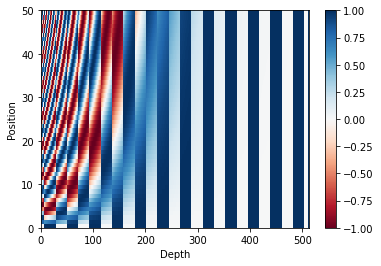

In [ ]:
# Получаем 50 строк по 512 значений
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Замаскируйте все маркеры площадок в пакете последовательности. Это гарантирует, что модель не обрабатывает отступы как входные данные. Маска указывает, где присутствует значение пэда 0 : она выводит 1 в этих местах и 0 противном случае.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32) # 1 if element is null, otherwise - 0
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

Маска упреждающего просмотра используется для маскировки будущих токенов в последовательности. Другими словами, маска указывает, какие записи не следует использовать.

Это означает, что для предсказания третьего слова будут использоваться только первое и второе слово. Аналогично для предсказания четвертого слова будут использоваться только первое, второе и третье слово и так далее.



In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0) # Copy a tensor setting everything outside a central band in each innermost matrix to zero.
  return mask  # (seq_len, seq_len) 

In [ ]:
x = tf.random.uniform((1, 3))
print(x)
temp = create_look_ahead_mask(x.shape[1])
temp

tf.Tensor([[0.8062663  0.6184777  0.62404716]], shape=(1, 3), dtype=float32)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Функция внимания, используемая преобразователем, принимает три входа: Q (запрос), K (ключ), V (значение). Уравнение, используемое для расчета весов внимания:


$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

Внимание скалярного произведения масштабируется с коэффициентом квадратного корня из глубины. Это сделано потому, что для больших значений глубины скалярное произведение увеличивается по величине, подталкивая функцию softmax, где у него есть небольшие градиенты, что приводит к очень жесткому softmax.

Например, предположим, что Q и K имеют среднее значение 0 и дисперсию 1. Их матричное умножение будет иметь среднее значение 0 и дисперсию dk . Следовательно, для масштабирования используется квадратный корень из dk (а не какое-либо другое число), потому что матрица Q и K должна иметь среднее значение 0 и дисперсию 1, и вы получите более мягкий softmax.

Маска умножается на -1e9 (близко к отрицательной бесконечности). Это сделано потому, что маска суммируется с умножением масштабированной матрицы Q и K и применяется непосредственно перед softmax. Цель состоит в том, чтобы обнулить эти ячейки, и большие отрицательные входные данные для softmax близки к нулю на выходе.



In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Поскольку нормализация softmax выполняется для K, его значения определяют степень важности, придаваемой Q.

Выходные данные представляют собой умножение весов внимания и вектора V (значения). Это гарантирует, что слова, на которых вы хотите сосредоточиться, останутся как есть, а нерелевантные слова будут удалены.



In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 10]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.   0.   0.5  0.5 ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.     5.5 ]
 [ 10.     0.  ]
 [277.75   2.75]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Многоголовое внимание состоит из четырех частей:

* Слои линейные и разбиваются на головы.
* Повышенное внимание к скалярному продукту
* Конкатенация голов.
* Финальный линейный слой.

Каждый блок внимания с несколькими головами получает три входа; Q (запрос), K (ключ), V (значение). Они проходят через линейные (плотные) слои и разбиваются на несколько головок.

scaled_dot_product_attention определенный выше, применяется к каждой голове (транслируется для эффективности). На этапе внимания необходимо использовать соответствующую маску. Затем вывод внимания для каждой головы объединяется (с использованием tf.transpose и tf.reshape ) и пропускается через последний слой Dense .

Вместо одной единственной головы внимания Q, K и V разделены на несколько голов, потому что это позволяет модели совместно обращать внимание на информацию в разных положениях из разных пространств представления. После разделения каждая голова имеет уменьшенную размерность, поэтому общая стоимость вычислений такая же, как и внимание одной головы с полной размерностью.



In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    # If one component of shape is the special value -1, the size of that dimension is computed so that 
    # the total size remains constant. In particular, a shape of [-1] flattens into 1-D. 
    # At most one component of shape can be -1.
    
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Создайте слой MultiHeadAttention чтобы попробовать. В каждом месте в последовательности y MultiHeadAttention запускает все 8 головок внимания по всем другим местам в последовательности, возвращая новый вектор той же длины в каждом месте.



In [ ]:
temp_mha = MultiHeadAttention(d_model=10, num_heads=2)
y = tf.random.uniform((2, 3, 10))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
print('Выходные размерности:  \n')
out.shape, attn.shape

X: 
 tf.Tensor(
[[[-8.3446294e-02 -1.1372101e+00  1.7035490e-01  8.1131881e-01
    1.1187821e-01 -1.3373218e+00  3.5845959e-01  2.4289222e-01
    1.4814006e+00 -1.2713318e-01]
  [-4.4430542e-01 -1.2427014e+00  2.4207979e-01  6.1922336e-01
   -7.2514206e-02 -6.2541550e-01 -7.4294431e-04  2.4274252e-01
    8.6139941e-01 -2.3329727e-01]
  [ 7.6528476e-03 -8.0667156e-01  3.6338526e-01  7.9842746e-01
    6.4593959e-01 -8.5639685e-01  6.7565972e-01  6.3925183e-01
    1.8766478e-01 -5.4372984e-01]]

 [[ 4.3565303e-01 -5.1512593e-01  1.6545182e-02  1.0204152e+00
    1.1188320e-01 -6.9260621e-01  3.5381642e-01  4.6537798e-02
    9.2674851e-01 -2.6420832e-01]
  [ 5.2235380e-02 -1.2927507e+00  5.9865481e-01  3.7441763e-01
    1.3769303e-02 -9.7013462e-01 -2.2618605e-01  1.9565576e-01
    1.0930191e+00 -4.4620234e-01]
  [ 3.5221142e-01 -8.4387583e-01  5.5822504e-01  3.8493225e-01
    5.1525193e-01 -1.1740443e+00  6.2471372e-01  4.2284104e-01
    9.1830796e-01 -6.8576860e-01]]], shape=(2, 3, 10), d

(TensorShape([2, 3, 10]), TensorShape([2, 2, 3, 3]))

## Point wise feed forward network

Сеть с точечной прямой связью состоит из двух полностью связанных слоев с активацией ReLU между ними.


In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Модель трансформера следует той же общей схеме, что и стандартная последовательность действий с моделью внимания .

Входное предложение проходит через N уровней кодировщика, которые генерируют выходные данные для каждого слова / токена в последовательности.
Декодер отслеживает вывод кодировщика и свой собственный ввод (самовнимание), чтобы предсказать следующее слово.


### Encoder layer

Каждый уровень кодировщика состоит из подслоев:

Многоголовое внимание (с дополнительной маской)
Точечные сети прямого распространения.
Каждый из этих подуровней имеет остаточную связь вокруг себя, за которой следует нормализация уровня. Остаточные соединения помогают избежать проблемы исчезающего градиента в глубоких сетях.

Результатом каждого подслоя является LayerNorm(x + Sublayer(x)) . Нормализация выполняется по d_model (последняя). В трансформаторе N слоев кодировщика.



In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Каждый слой декодера состоит из подслоев:

Замаскированное внимание с несколькими головами (с опережающей маской и дополнительной маской)
Многоголовое внимание (с дополнительной маской). V (значение) и K (ключ) получают выходной сигнал энкодера в качестве входных данных. Q (запрос) получает выходные данные от подуровня замаскированного многоголового внимания.
Точечные сети прямого распространения
Каждый из этих подуровней имеет остаточную связь вокруг себя, за которой следует нормализация уровня. Результатом каждого подслоя является LayerNorm(x + Sublayer(x)) . Нормализация выполняется по d_model (последняя).

В трансформаторе N слоев декодера.

Поскольку Q принимает выходные данные от первого блока внимания декодера, а K принимает выходные данные кодировщика, веса внимания представляют важность, придаваемую входу декодера на основе выходных данных кодера. Другими словами, декодер предсказывает следующее слово, глядя на выходные данные кодировщика и самостоятельно присматриваясь к своим собственным выходным данным. См. Демонстрацию выше в разделе «Внимание к скалярному произведению».



In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1] #40
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   1.            1.            0.96466162 ...    0.00010746
     0.00010366    0.00010366]
 [   2.            2.            1.92932324 ...    0.00021492
     0.00020733    0.00020733]
 ...
 [9997.         9997.         9643.72221425 ...    1.07428545
     1.03632194    1.03632194]
 [9998.         9998.         9644.68687587 ...    1.07439291
     1.0364256     1.0364256 ]
 [9999.         9999.         9645.65153749 ...    1.07450037
     1.03652927    1.03652927]]
(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   1.            1.            0.96466162 ...    0.00010746
     0.00010366    0.00010366]
 [   2.            2.            1.92932324 ...    0.00021492
     0.00020733    0.00020733]
 ...
 [4997.         4997.         4820.4141147  ...    0.53698153
     0.51800547    0.51800547]
 [4998.         4998.         4821.37877632 ...    0.53708899
     0.51810914    0.51810914]
 [4999.         4999.         4822.34343794 ...    0.53719645
     0.5182128     0.5182128 ]]


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   1.            1.            0.96466162 ...    0.00010746
     0.00010366    0.00010366]
 [   2.            2.            1.92932324 ...    0.00021492
     0.00020733    0.00020733]
 ...
 [9997.         9997.         9643.72221425 ...    1.07428545
     1.03632194    1.03632194]
 [9998.         9998.         9644.68687587 ...    1.07439291
     1.0364256     1.0364256 ]
 [9999.         9999.         9645.65153749 ...    1.07450037
     1.03652927    1.03652927]]
[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   1.            1.            0.96466162 ...    0.00010746
     0.00010366    0.00010366]
 [   2.            2.            1.92932324 ...    0.00021492
     0.00020733    0.00020733]
 ...
 [5997.         5997.         5785.07573461 ...    0.64444231
     0.62166877    0.62166877]
 [5998.         5998.         5786.04039623 ...    0.64454978
     0.621772

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_ru.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    step = tf.cast(step, np.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

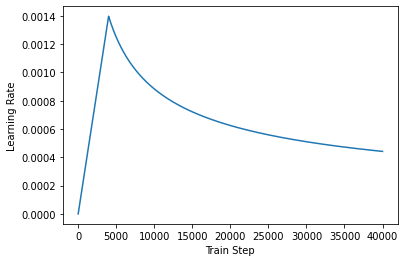

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   1.            1.            0.86596432 ...    0.00013335
     0.00011548    0.00011548]
 [   2.            2.            1.73192865 ...    0.0002667
     0.00023096    0.00023096]
 ...
 [8178.         8178.         7081.85623644 ...    1.09055383
     0.94438071    0.94438071]
 [8179.         8179.         7082.72220076 ...    1.09068718
     0.94449619    0.94449619]
 [8180.         8180.         7083.58816509 ...    1.09082053
     0.94461166    0.94461166]]
[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   1.            1.            0.86596432 ...    0.00013335
     0.00011548    0.00011548]
 [   2.            2.            1.73192865 ...    0.0002667
     0.00023096    0.00023096]
 ...
 [8244.         8244.         7139.00988178 ...    1.09935507
     0.95200227    0.95200227]
 [8245.         8245.         7139.8758461  ...    1.09948842
     0.95211775

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Цель делится на tar_inp и tar_real. tar_inp передается декодеру в качестве входных данных. tar_real - это тот же самый ввод, сдвинутый на 1: в каждом месте tar_input tar_real содержит следующий токен, который должен быть предсказан.

Например, sentence = "SOS Лев в джунглях спит EOS"

tar_inp = "SOS tar_inp лев в джунглях"

tar_real = "Лев в джунглях спит EOS"

Преобразователь - это авторегрессивная модель: он делает прогнозы по частям и использует свои выходные данные, чтобы решить, что делать дальше.

Во время обучения в этом примере используется принуждение учителя (как в учебнике по созданию текста ). Принуждение учителя передает истинный результат следующему временному шагу независимо от того, что модель предсказывает на текущем временном шаге.

Поскольку преобразователь предсказывает каждое слово, самовнимание позволяет ему смотреть на предыдущие слова во входной последовательности, чтобы лучше предсказать следующее слово.

Чтобы модель не просматривала ожидаемый результат, в модели используется маска просмотра вперед.



In [ ]:
EPOCHS = 30

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Ru is used as the input language and English is the target language.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0325 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9803 Accuracy 0.0007
Epoch 1 Batch 100 Loss 8.8909 Accuracy 0.0209
Epoch 1 Batch 150 Loss 8.7923 Accuracy 0.0327
Epoch 1 Batch 200 Loss 8.6688 Accuracy 0.0432
Epoch 1 Batch 250 Loss 8.5136 Accuracy 0.0522
Epoch 1 Batch 300 Loss 8.3356 Accuracy 0.0615
Epoch 1 Batch 350 Loss 8.1465 Accuracy 0.0698
Epoch 1 Batch 400 Loss 7.9639 Accuracy 0.0770
Epoch 1 Batch 450 Loss 7.7970 Accuracy 0.0824
Epoch 1 Batch 500 Loss 7.6496 Accuracy 0.0879
Epoch 1 Batch 550 Loss 7.5130 Accuracy 0.0947
Epoch 1 Batch 600 Loss 7.3825 Accuracy 0.1022
Epoch 1 Batch 650 Loss 7.2584 Accuracy 0.1091
Epoch 1 Batch 700 Loss 7.1415 Accuracy 0.1157
Epoch 1 Batch 750 Loss 7.0298 Accuracy 0.1226
Epoch 1 Batch 800 Loss 6.9265 Accuracy 0.1290
Epoch 1 Batch 850 Loss 6.8286 Accuracy 0.1351
Epoch 1 Batch 900 Loss 6.7385 Accuracy 0.1408
Epoch 1 Batch 950 Loss 6.6517 Accuracy 0.1464
Epoch 1 Batch 1000 Loss 6.5730 Accuracy 0.1517
Epoch 1 Batch 1050 Loss 6.4984 Accur

## Evaluate

Для оценки используются следующие шаги:

Закодируйте входное предложение с помощью русского токенизатора ( tokenizer_pt ). Кроме того, добавьте начальный и конечный токены, чтобы ввод был эквивалентен тому, с чем обучается модель. Это вход энкодера.
Вход декодера - это start token == tokenizer_en.vocab_size .
Рассчитайте маски заполнения и маски прогнозирования.
Затем decoder выводит прогнозы, глядя на encoder output и собственные выходные данные (самовнимание).
Выберите последнее слово и вычислите его argmax.
Конкатентируйте предсказанное слово на вход декодера при передаче его в декодер.
В этом подходе декодер предсказывает следующее слово на основе предсказанных им предыдущих слов.


In [ ]:
def evaluate(inp_sentence):
  start_token = [tokenizer_ru.vocab_size]
  end_token = [tokenizer_ru.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_ru.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_ru.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_ru.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [ ]:
def translate(sentence, plot='decoder_layer4_block2'):
  result, attention_weights = evaluate(sentence)
  # print(attention_weights)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

После 15-ти эпох

In [ ]:
translate('Осенним вечером шёл дождь!')

Input: Осенним вечером шёл дождь!
Predicted translation: the eyeball is rained at night .


In [ ]:
translate('он собирается домой')

Input: он собирается домой
Predicted translation: he 's going to come home .


После 30 эпох

Input: Осенним вечером шёл дождь!
Predicted translation: it was a rained evening rain .


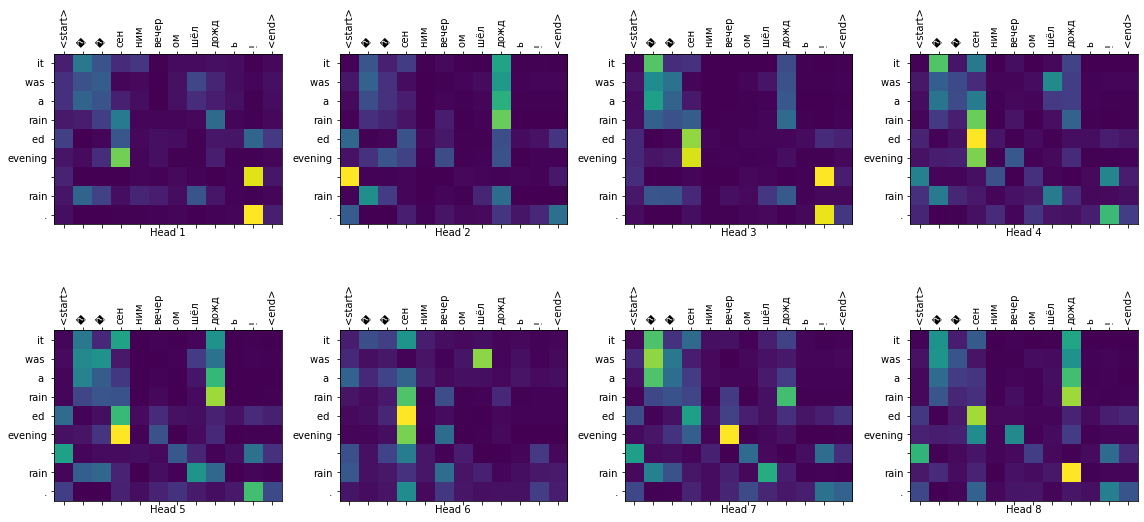

In [ ]:
translate('Осенним вечером шёл дождь!')

Input: он собирается домой
Predicted translation: he 's going home .


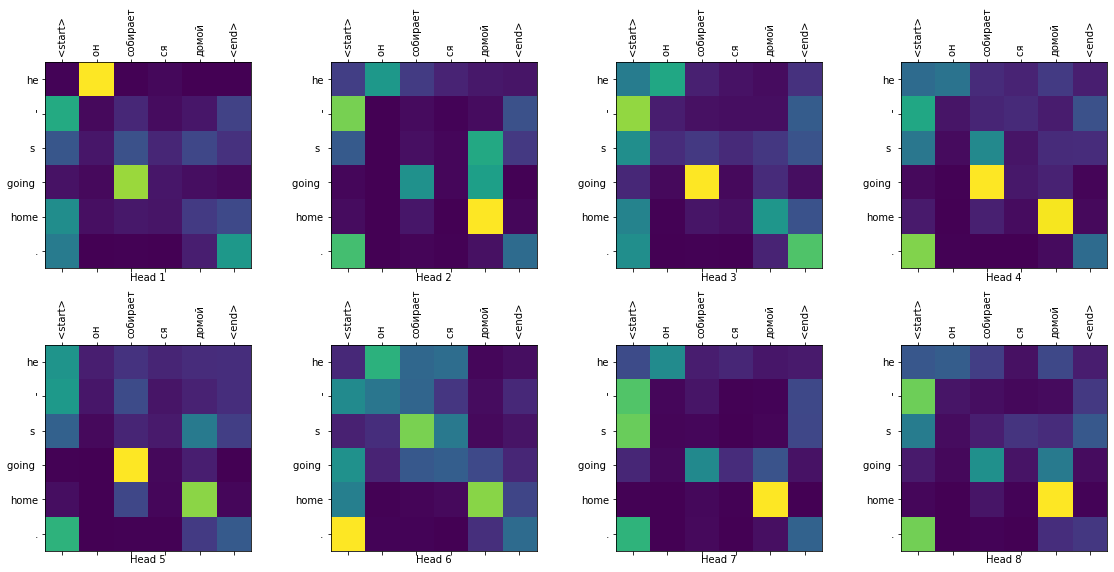

In [ ]:
translate('он собирается домой')